## Imports

In [0]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  


import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision.transforms as transforms


print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)



Python: 3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]
Pytorch: 1.3.0+cu100


## Hyperparameters

In [0]:
n_epochs = 15
batch_size = 64
lr = 0.01
k = 3

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from google.colab import drive
drive.mount('/content/drive')
my_path = '/content/drive/My Drive/Data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Load CIFAR10

In [0]:
# define series of transforms to pre process images 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# load training set 
cifar10_trainset = torchvision.datasets.CIFAR10(my_path, train=True, transform=transform, download=True)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=32, shuffle=True)
print(f'>>>>>>> Total number of training images: {len(cifar10_trainset)}')

# load test set 
cifar10_testset = torchvision.datasets.CIFAR10(my_path, train=False, transform=transform, download=True)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=32, shuffle=False)
print(f'>>>>>>> Total number of test images: {len(cifar10_testset)}')

Files already downloaded and verified
>>>>>>> Total number of training images: 50000
Files already downloaded and verified
>>>>>>> Total number of test images: 10000


In [0]:
# helper function to unnormalize and plot image 
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [0]:
# let's take a look at the data:
# grab a training batch
# display sample from dataset 
imgs, labels = next(iter(cifar10_trainloader))

print(f'Batch size: {len(imgs)}')
print(f'Labels: {len(labels)}')
print(f'image shape: {imgs[0].shape}')
print(f'first two labels: {labels[0:2]}')
print(f'Actual labels: {classes[labels[0]], classes[labels[1]]}')

Batch size: 32
Labels: 32
image shape: torch.Size([3, 32, 32])
first two labels: tensor([9, 2])
Actual labels: ('truck', 'bird')


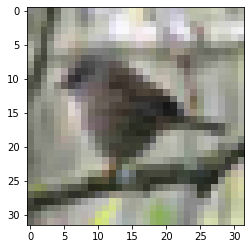

bird


In [0]:
imshow(imgs[1])
print(f'{classes[labels[1]]}')

In [0]:
total_size = len(cifar10_trainset)
print(f'Total number of training images: {total_size}')

Total number of training images: 50000


In [0]:
split1 = total_size // 4
split2 = split1*2
split3 = split1*3
print(f'0 --- {split1} --- {split2} --- {split3} --- {total_size}')


indices = list(range(total_size))

0 --- 12500 --- 25000 --- 37500 --- 50000


In [0]:
# create datasets from the above loaded CIFAR 10
indices = list(range(total_size))

shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]

target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:]

# Samples elements randomly from a given list of indices, without replacement... used to create a random subset of the dataset
shadow_train_sampler = SubsetRandomSampler(shadow_train_idx)
shadow_out_sampler = SubsetRandomSampler(shadow_out_idx)

target_train_sampler = SubsetRandomSampler(target_train_idx)
target_out_sampler = SubsetRandomSampler(target_out_idx)

# grab a sampler of the dataset
shadow_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_train_sampler)
shadow_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_out_sampler)

target_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_train_sampler)
target_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_out_sampler)


The Target Model
---
The target model is the model you are trying to attack. It might be a black-box or a white-box attack whether you have access to the model or not.

In this project, we take the responsibility of training the target model, which is not TRUE in a real scenario (duh!).. The target model is the model you want to attack. In reality, it's already trained and perhaps deployed! 

Anyway, let's first train a traget model.

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input channels = 3, output channels=6, kernel_size =5 
        self.pool = nn.MaxPool2d(2, 2)  # kernel size = 2, stride = 2
        self.conv2 = nn.Conv2d(6, 16, 5) 
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [0]:
# to facilitate the training process, I am going to create a training funciton
def train(net, data_loader, test_loader, optimizer, criterion, n_epochs, classes=None, verbose=False):
    
    losses = []

    for epoch in range(n_epochs):
        
        net.train()

        for i, batch in enumerate(data_loader):

            imgs, labels = batch

            optimizer.zero_grad()

            outputs = net(imgs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            losses.append(loss.item())

            if verbose:
                print("[%d/%d][%d/%d] loss = %f" % (epoch, n_epochs, i, len(data_loader), loss.item()))

        # evaluate performance on testset at the end of each epoch
        print("[%d/%d]" %(epoch, n_epochs))

        print("Training:")
        train_accuracy = eval_target_net(net, data_loader, classes=classes)

        print("Test:")
        test_accuracy = eval_target_net(net, test_loader, classes=classes)

    return train_accuracy, test_accuracy

In [0]:
# a function to evaluate the performance of the target network

def eval_target_net(net, testloader, classes=None):

    if classes is not None:
        class_correct = np.zeros(10)
        class_total = np.zeros(10)
    total = 0
    correct = 0
    
    with torch.no_grad():
        net.eval()
        for i, (imgs, lbls) in enumerate(testloader):

            output = net(imgs)

            predicted = output.argmax(dim=1)

            total += imgs.size(0)
            correct += predicted.eq(lbls).sum().item() # eq: element wise equality

            if classes is not None:
                for prediction, lbl in zip(predicted, lbls):

                    class_correct[lbl] += prediction == lbl
                    class_total[lbl] += 1
                    
    accuracy = 100*(correct/total)
    
    if classes is not None:
        for i in range(len(classes)):
            print('Accuracy of %s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    print("\nAccuracy = %.2f %%\n\n" % (accuracy) )
    
    return accuracy

In [0]:
target_net = Net()
target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=0.001)

In [0]:
train(target_net, target_train_loader, cifar10_testloader, target_optim, target_loss, n_epochs=3, classes=classes)

[0/3]
Training:
Accuracy of airplane : 72.39 %
Accuracy of automobile : 81.46 %
Accuracy of bird : 41.24 %
Accuracy of cat : 50.16 %
Accuracy of deer : 55.61 %
Accuracy of dog : 55.75 %
Accuracy of frog : 74.07 %
Accuracy of horse : 70.55 %
Accuracy of ship : 71.29 %
Accuracy of truck : 77.42 %

Accuracy = 64.83 %


Test:
Accuracy of airplane : 64.80 %
Accuracy of automobile : 70.30 %
Accuracy of bird : 31.00 %
Accuracy of cat : 39.20 %
Accuracy of deer : 43.50 %
Accuracy of dog : 44.70 %
Accuracy of frog : 66.90 %
Accuracy of horse : 60.20 %
Accuracy of ship : 62.40 %
Accuracy of truck : 66.00 %

Accuracy = 54.90 %


[1/3]
Training:
Accuracy of airplane : 69.79 %
Accuracy of automobile : 89.59 %
Accuracy of bird : 44.09 %
Accuracy of cat : 50.91 %
Accuracy of deer : 63.19 %
Accuracy of dog : 59.94 %
Accuracy of frog : 63.66 %
Accuracy of horse : 79.45 %
Accuracy of ship : 66.64 %
Accuracy of truck : 70.76 %

Accuracy = 65.68 %


Test:
Accuracy of airplane : 62.20 %
Accuracy of automob

(65.72, 54.50000000000001)

Let's run some predictions on the Target model:
--

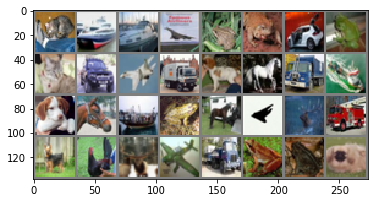

GroundTruth:    cat  ship  ship airplane
Preditions:    cat automobile automobile airplane


In [0]:
dataiter = iter(cifar10_testloader)
images, labels = dataiter.next() # grab a batch of images

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# test the model on these images
target_results = target_net(images)

_, predicted = torch.max(target_results, 1)
print('Preditions: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))


Train a SHADOW network
---
In practice, you need to mimic the behavior of the target model. You need to create a NN or other ML model that will produce a very similar results. In this example, we will reuse the exact NN used inthe target model. For your ICP, use two different types of neural networks...

In [0]:
shadow_net = Net()
shadow_loss = nn.CrossEntropyLoss()
shadow_optim = optim.Adam(shadow_net.parameters(), lr=0.001)


In [0]:
train(shadow_net, shadow_train_loader, cifar10_testloader, shadow_optim, shadow_loss, n_epochs=5, classes=classes)

[0/5]
Training:
Accuracy of airplane : 32.97 %
Accuracy of automobile : 66.83 %
Accuracy of bird : 27.44 %
Accuracy of cat : 2.67 %
Accuracy of deer : 34.17 %
Accuracy of dog : 39.11 %
Accuracy of frog : 54.95 %
Accuracy of horse : 33.60 %
Accuracy of ship : 61.90 %
Accuracy of truck : 27.25 %

Accuracy = 38.08 %


Test:
Accuracy of airplane : 33.00 %
Accuracy of automobile : 65.70 %
Accuracy of bird : 30.30 %
Accuracy of cat : 2.00 %
Accuracy of deer : 35.30 %
Accuracy of dog : 36.70 %
Accuracy of frog : 54.90 %
Accuracy of horse : 37.90 %
Accuracy of ship : 59.40 %
Accuracy of truck : 22.50 %

Accuracy = 37.77 %


[1/5]
Training:
Accuracy of airplane : 35.72 %
Accuracy of automobile : 37.43 %
Accuracy of bird : 36.59 %
Accuracy of cat : 43.88 %
Accuracy of deer : 24.50 %
Accuracy of dog : 31.74 %
Accuracy of frog : 61.69 %
Accuracy of horse : 42.82 %
Accuracy of ship : 62.69 %
Accuracy of truck : 49.63 %

Accuracy = 42.82 %


Test:
Accuracy of airplane : 36.60 %
Accuracy of automobil

(53.647999999999996, 49.09)

ATTACK MODEL
---
Now we have mimced the target model, by creating the shadow model, we will train an attack model. The attack model goal is map a given propability distribution (the output of the target model) to {1,0}, where 1 means that the input image used to produce the output was used in training the target model.

To do so, we need to train a simple classifier. Input data are inference results and output are 1 and 0.

inference results from the Shadow model that was used in training the shadow model will be mapped to 1. Otherwise, inference results will be mapped to 0 (was not used in training the model).

Then we will test our model on the Target model. Similarly, we know which data was used to train the target model, and therefore we can assess the accuracy of our model. Let's get to work...

In [0]:
class classifier(nn.Module): 
    
    def __init__(self, n_in=3, n_out=1, n_hidden=64):
        super(classifier, self).__init__()
        self.fc1 = nn.Linear(n_in, n_hidden)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(n_hidden, 32)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(32, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    


In [0]:
attack_net = classifier()
attack_loss = nn.BCELoss()
attack_optim = optim.Adam(attack_net.parameters(), lr=0.001)

In [0]:
train_attacker(attack_net, shadow_net, shadow_train_loader, shadow_out_loader, attack_optim, criterion= attack_loss, n_epochs=3, k=3)

[0/3][0/196] loss = 0.69, accuracy = 43.75
[0/3][1/196] loss = 0.69, accuracy = 48.05
[0/3][2/196] loss = 0.69, accuracy = 50.26
[0/3][3/196] loss = 0.69, accuracy = 50.39
[0/3][4/196] loss = 0.69, accuracy = 50.94
[0/3][5/196] loss = 0.69, accuracy = 51.04
[0/3][6/196] loss = 0.69, accuracy = 51.34
[0/3][7/196] loss = 0.69, accuracy = 51.86
[0/3][8/196] loss = 0.69, accuracy = 51.39
[0/3][9/196] loss = 0.69, accuracy = 51.02
[0/3][10/196] loss = 0.69, accuracy = 51.42
[0/3][11/196] loss = 0.69, accuracy = 51.63
[0/3][12/196] loss = 0.69, accuracy = 52.40
[0/3][13/196] loss = 0.69, accuracy = 52.34
[0/3][14/196] loss = 0.69, accuracy = 52.19
[0/3][15/196] loss = 0.69, accuracy = 51.61
[0/3][16/196] loss = 0.69, accuracy = 51.52
[0/3][17/196] loss = 0.69, accuracy = 51.82
[0/3][18/196] loss = 0.69, accuracy = 51.81
[0/3][19/196] loss = 0.69, accuracy = 51.68
[0/3][20/196] loss = 0.69, accuracy = 51.60
[0/3][21/196] loss = 0.69, accuracy = 51.14
[0/3][22/196] loss = 0.70, accuracy = 50.7

In [0]:
def train_attacker(attack_net, shadow, shadow_train, shadow_out, optimizer, criterion, n_epochs, k):
    
    """
    Trains attack model (classifies a sample as in or out of training set) using
    shadow model outputs (probabilities for sample class predictions). 
    The type of shadow model used can vary.
    """
        
    in_predicts=[]
    out_predicts=[]
    losses = []
    
    shadow_net=shadow
    shadow_net.eval()

    for epoch in range(n_epochs):
       
        total = 0
        correct = 0


        for i, ((train_imgs, _), (out_imgs, _)) in enumerate(zip(shadow_train, shadow_out)):

            if train_imgs.shape[0] != out_imgs.shape[0]: 
                break
                
            mini_batch_size = train_imgs.shape[0]
            
            # inference
            train_posteriors = F.softmax(shadow_net(train_imgs), dim=1)
            out_posteriors = F.softmax(shadow_net(out_imgs), dim=1)
                            

            train_sort, _ = torch.sort(train_posteriors, descending=True) # sort probabilities of each prediction
            train_top_k = train_sort[:,:k].clone()
        

            out_sort, _ = torch.sort(out_posteriors, descending=True)
            out_top_k = out_sort[:,:k].clone()


            train_lbl = torch.ones(mini_batch_size)
            out_lbl = torch.zeros(mini_batch_size)

            optimizer.zero_grad()

            train_predictions =  torch.squeeze(attack_net(train_top_k))
            out_predictions =  torch.squeeze(attack_net(out_top_k))

            loss_train = criterion(train_predictions, train_lbl)
            loss_out = criterion(out_predictions, out_lbl)

            loss = (loss_train + loss_out) / 2
            
            loss.backward()

            optimizer.step()

            
            correct += ((train_predictions)>=0.5).sum().item()
            correct += ((out_predictions)<0.5).sum().item()
            total += train_predictions.size(0) + out_predictions.size(0)


            print("[%d/%d][%d/%d] loss = %.2f, accuracy = %.2f" % (epoch, n_epochs, i, len(shadow_train), loss.item(), 100 * correct / total))
    print('DONE...')
            

In [0]:
def eval_attack_net(attack_net, target, target_train, target_out, k):
    """Assess accuracy, precision, and recall of attack model for in training set/out of training set classification.
    Edited for use with SVCs."""
    
    in_predicts=[]
    out_predicts=[]
    losses = []

    target_net=target
    target_net.eval()
        
    attack_net.eval()

    
    precisions = []
    recalls = []
    accuracies = []

    #for threshold in np.arange(0.5, 1, 0.005):
    thresholds = np.arange(0.5, 1, 0.005)

    total = np.zeros(len(thresholds))
    correct = np.zeros(len(thresholds))

    true_positives = np.zeros(len(thresholds))
    false_positives = np.zeros(len(thresholds))
    false_negatives = np.zeros(len(thresholds))   
 
    train_top = np.empty((0,2))
    out_top = np.empty((0,2))
    
    for i, ((train_imgs, _), (out_imgs, _)) in enumerate(zip(target_train, target_out)):


        mini_batch_size = train_imgs.shape[0]
        
        #[mini_batch_size x num_classes] tensors, (0,1) probabilities for each class for each sample)
        traininputs=train_imgs.view(train_imgs.shape[0], -1)
        outinputs=out_imgs.view(out_imgs.shape[0], -1)
            
            
     
        #[k x mini_batch_size] tensors, (0,1) probabilities for top k probable classes
        train_sort, _ = torch.sort(train_posteriors, descending=True)
        train_top_k = train_sort[:,:k].clone()

        out_sort, _ = torch.sort(out_posteriors, descending=True)
        out_top_k = out_sort[:,:k].clone()
        
        #Collects probabilities for predicted class.
        for p in train_top_k:
            in_predicts.append((p.max()).item())
        for p in out_top_k:
            out_predicts.append((p.max()).item())
        
        train_top = np.vstack((train_top,train_top_k[:,:2].cpu().detach().numpy()))
        out_top = np.vstack((out_top, out_top_k[:,:2].cpu().detach().numpy()))

     
        train_lbl = torch.ones(mini_batch_size)
        out_lbl = torch.zeros(mini_batch_size)
        
        #Takes in probabilities for top k most likely classes, outputs ~1 (in training set) or ~0 (out of training set)
        train_predictions = F.sigmoid(torch.squeeze(attack_net(train_top_k)))
        out_predictions = F.sigmoid(torch.squeeze(attack_net(out_top_k)))


        for j, t in enumerate(thresholds):
            true_positives[j] += (train_predictions >= t).sum().item()
            false_positives[j] += (out_predictions >= t).sum().item()
            false_negatives[j] += (train_predictions < t).sum().item()
            #print(train_top >= threshold)


            #print((train_top >= threshold).sum().item(),',',(out_top >= threshold).sum().item())

            correct[j] += (train_predictions >= t).sum().item()
            correct[j] += (out_predictions < t).sum().item()
            total[j] += train_predictions.size(0) + out_predictions.size(0)

    #print(true_positives,',',false_positives,',',false_negatives)

    for j, t in enumerate(thresholds):
        accuracy = 100 * correct[j] / total[j]
        precision = true_positives[j] / (true_positives[j] + false_positives[j]) if true_positives[j] + false_positives[j] != 0 else 0
        recall = true_positives[j] / (true_positives[j] + false_negatives[j]) if true_positives[j] + false_negatives[j] !=0 else 0
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)

        print("threshold = %.4f, accuracy = %.2f, precision = %.2f, recall = %.2f" % (t, accuracy, precision, recall))
        

        
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

In [0]:
eval_attack_net(attack_net, target_net, target_train_loader, target_out_loader, k)

print("\nPerformance on training set: ")
train_accuracy = eval_target_net(target_net, target_train_loader, classes=None)

print("\nPerformance on test set: ")
test_accuracy = eval_target_net(target_net, cifar10_testloader, classes=None)

NameError: ignored